## Langchain ChatModels

In [27]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core

In [1]:
import os
GEMINI_API_KEY = os.environ['GOOGLE_API_KEY']

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY,
    temperature=0.5
)

In [3]:
result = llm.invoke("Hi")
result # Metadata

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-43d9ba40-ae22-4ac4-bd49-c24ff09933ad-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [4]:
result.content

'Hi there! How can I help you today?'

In [5]:
from langchain_core.messages import HumanMessage, AIMessage

msg = HumanMessage(content="Hi")

messages = [msg]

result = llm.invoke(messages)
result.content

'Hi there! How can I help you today?'

In [6]:
messages = [
    HumanMessage(content="Hi"),
    AIMessage(content="Hi there! How can I help you today?"),
    HumanMessage(content="What is Langchain?")
]

result = llm.invoke(messages)
result.content

"LangChain is a framework for developing applications powered by language models.  Instead of just interacting with a language model through a single prompt, LangChain allows you to build more complex and sophisticated applications by:\n\n* **Connecting to multiple language models:**  You're not locked into a single provider.  LangChain can work with OpenAI, Hugging Face Hub models, and many others.\n\n* **Managing memory:**  LangChain provides mechanisms to maintain context across multiple interactions with the language model, improving the coherence and accuracy of the application's responses.  This is crucial for tasks that require remembering previous interactions or information.\n\n* **Chain of thought prompting:**  LangChain facilitates the use of advanced prompting techniques like chain of thought, which can significantly improve the reasoning abilities of language models.\n\n* **Integrating with external data sources:**  LangChain allows you to connect your language model to da

In [7]:
messages = [
    HumanMessage(content="Hi"),
    AIMessage(content="Hi there! How can I help you today?"),
    HumanMessage(content="What is Langchain?"),
    AIMessage(content="LangChain is a framework for developing applications powered by language models."),
    HumanMessage(content="Where can I learn?")
]

result = llm.invoke(messages)
result.content

'You can learn about LangChain from several resources:\n\n* **Official LangChain Documentation:** This is the most comprehensive and up-to-date source of information.  It includes tutorials, examples, and API references.  Start here: [https://python.langchain.com/en/latest/](https://python.langchain.com/en/latest/)\n\n* **LangChain\'s GitHub Repository:**  The GitHub repository provides access to the source code, issue tracking, and community contributions.  It\'s a great place to dive deeper and see how things work under the hood: [https://github.com/langchain-ai/langchain](https://github.com/langchain-ai/langchain)\n\n* **Tutorials and Blog Posts:** Many tutorials and blog posts are available online that cover various aspects of LangChain. Search for "LangChain tutorial" or "LangChain example" on Google or your preferred search engine.  Look for tutorials that focus on specific applications or features that interest you.\n\n* **YouTube Tutorials:** Several YouTube channels cover Lang

In [8]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## State

In [9]:
from typing_extensions import TypedDict

class LearningState(TypedDict):
    prompt: str

In [10]:
mac_state : LearningState = LearningState(prompt="Hello from Macbook Air M1")

In [11]:
print(mac_state)
print(mac_state["prompt"])
print(mac_state["prompt"] + ". I am built by Apple Inc.")
print(type(mac_state))

{'prompt': 'Hello from Macbook Air M1'}
Hello from Macbook Air M1
Hello from Macbook Air M1. I am built by Apple Inc.
<class 'dict'>


## Nodes

In [12]:
def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)
    return {"prompt": state['prompt'] + " I am "}

def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)
    return {'prompt': state['prompt'] + "a Macbook Air M1"}

## Edges and Graph Connections

In [13]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

builder: StateGraph = StateGraph(state_schema=LearningState)

In [14]:
print(type(builder))

<class 'langgraph.graph.state.StateGraph'>


In [15]:
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

In [16]:
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

In [17]:
graph: CompiledStateGraph = builder.compile()

In [18]:
print(graph)
print(type(graph))
print(graph.get_graph())

<class 'langgraph.graph.state.CompiledStateGraph'>
Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


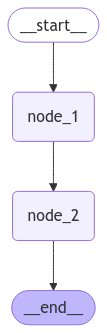

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invoke

In [20]:
graph.invoke({"prompt": "Hey"})

---Node 1 State--- {'prompt': 'Hey'}
---Node 2 State--- {'prompt': 'Hey I am '}


{'prompt': 'Hey I am a Macbook Air M1'}

## Using LLM in Nodes

In [21]:
from typing_extensions import TypedDict

class LLMAgentCall(TypedDict):
    prompt: str
    output: str

In [22]:
def node_1(state: LLMAgentCall):
    print("---Node 1 State---", state)
    prompt = state['prompt']
    ai_msg: AIMessage = llm.invoke(prompt)
    return {"prompt": prompt, "output": ai_msg.content}

In [23]:
greet_message = node_1(LLMAgentCall(prompt="Hi"))
greet_message

---Node 1 State--- {'prompt': 'Hi'}


{'prompt': 'Hi', 'output': 'Hi there! How can I help you today?'}

In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Build Graph
builder: StateGraph = StateGraph(state_schema=LLMAgentCall)

# Create Nodes
builder.add_node("node_1", node_1)

# Create Edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile Graph
graph: CompiledStateGraph = builder.compile()

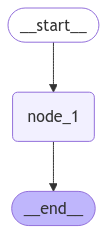

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
graph.invoke({"prompt": "Why langgraph is important?"})

---Node 1 State--- {'prompt': 'Why langgraph is important?'}


{'prompt': 'Why langgraph is important?',
 'output': "LangChain's LangGraph is important because it offers a powerful way to manage and orchestrate complex workflows involving large language models (LLMs).  Its significance stems from several key features:\n\n* **Modular and Extensible:** LangGraph allows you to break down complex LLM applications into smaller, manageable modules. This modularity promotes code reusability, easier debugging, and simpler maintenance.  You can easily add new modules or replace existing ones as needed, fostering flexibility and adaptability.\n\n* **Workflow Orchestration:**  It excels at orchestrating sequences of LLM calls and other operations.  This is crucial for tasks that require multiple steps, such as summarizing a document, extracting key information, and then generating a report.  LangGraph manages the flow of data between these steps efficiently.\n\n* **Improved Debugging and Monitoring:** The modular nature and explicit definition of workflows i